In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
# Dùng thư viện yfinance để tải dataset 
import yfinance as yf

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
import math

In [2]:
df = pd.read_csv('DOGE-USD.csv')

df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/1/2019,0.002346,0.002392,0.002322,0.002392,0.002392,17364744
1,1/2/2019,0.002388,0.002458,0.002372,0.002407,0.002407,18015392
2,1/3/2019,0.002404,0.002414,0.002356,0.002360,0.002360,17619234
3,1/4/2019,0.002364,0.002397,0.002274,0.002315,0.002315,19530100
4,1/5/2019,0.002320,0.002350,0.002280,0.002319,0.002319,17148586


**<h3>ARIMA 6-3-1</h3>**

In [3]:
df = df[['Date', 'Close']]
df = df.dropna() # Drop missing values
# df = df.reset_index(drop=True) # Reset the index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Split the data into training, testing, and validation sets
train_size = int(0.6 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]
print(df)

               Close
Date                
2019-01-01  0.002392
2019-01-02  0.002407
2019-01-03  0.002360
2019-01-04  0.002315
2019-01-05  0.002319
...              ...
2023-03-27  0.072895
2023-03-28  0.073823
2023-03-29  0.075627
2023-03-30  0.074245
2023-03-31  0.077035

[1551 rows x 1 columns]


In [4]:
print(len(df))
print(len(train_data))
print(train_size)

1551
930
930


In [5]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 50.8 MB/s eta 0:00:00


In [6]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-5147.275, Time=4.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5058.268, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5071.702, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5068.899, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5060.129, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-5096.670, Time=3.64 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5079.906, Time=3.72 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-5120.506, Time=6.29 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-5137.202, Time=4.89 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5073.719, Time=2.00 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-5116.575, Time=4.77 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-5084.148, Time=0.80 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-5142.789, Time=2.39 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-5149.070, Time=0.91 sec
 ARIMA(1,1,2)(0,0,0

ARIMA(order=(2, 1, 3), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [7]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(n_periods=len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [8]:
import datetime
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
print(last_index)
next_30_days_index = pd.date_range(start=last_index + datetime.timedelta(days=1), periods=30, freq='D')
print(next_30_days_index)
# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(next_30_days_index).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days)) 

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

2023-03-31 00:00:00
DatetimeIndex(['2023-04-01', '2023-04-02', '2023-04-03', '2023-04-04',
               '2023-04-05', '2023-04-06', '2023-04-07', '2023-04-08',
               '2023-04-09', '2023-04-10', '2023-04-11', '2023-04-12',
               '2023-04-13', '2023-04-14', '2023-04-15', '2023-04-16',
               '2023-04-17', '2023-04-18', '2023-04-19', '2023-04-20',
               '2023-04-21', '2023-04-22', '2023-04-23', '2023-04-24',
               '2023-04-25', '2023-04-26', '2023-04-27', '2023-04-28',
               '2023-04-29', '2023-04-30'],
              dtype='datetime64[ns]', freq='D')
Predicted closing prices for the next 30 days:
[0.18534301 0.18943558 0.19129133 0.19065409 0.18888475 0.18750191
 0.1871962  0.18773321 0.18845721 0.18885464 0.18881111 0.18852525
 0.18826559 0.18817992 0.18825246 0.18837731 0.18845808 0.18846282
 0.18841832 0.18837089 0.18835053 0.18835906 0.18838002 0.1883958
 0.18839882 0.18839222 0.18838378 0.18837934 0.18838005 0.18838347]


In [9]:
# 12. Đánh giá độ chính xác thuật toán
import sklearn.metrics as metrics
mae = mean_absolute_error(y_test,y_pred)
print('Testing MAE: ', mae)
mae = mean_absolute_error(y_val,y_pred_val)
print('Validation MAE: ', mae)


Testing MAE:  0.07508913076934276
Validation MAE:  0.10335810691821301


In [10]:
mse = mean_squared_error(y_test,y_pred)
print('Testing MSE: ', mse)
mse = mean_squared_error(y_val,y_pred_val)
print('Validation MSE: ', mse)

Testing MSE:  0.007375063798028558
Validation MSE:  0.010861771696077568


In [11]:
rmse = math.sqrt(mean_squared_error(y_test,y_pred))
print('Testing RMSE: ', rmse)
rmse = math.sqrt(mean_squared_error(y_val, y_pred_val))
print('Validation RMSE: ', rmse)

Testing RMSE:  0.08587819163226806
Validation RMSE:  0.10421982391118097


In [12]:
r2 = r2_score(y_test, y_pred)
print('Testing R-Square:', r2)
r2 = r2_score(y_val, y_pred_val)
print('Validation R-Square: ', r2)

Testing R-Square: -0.29772779620805667
Validation R-Square:  -59.188369434830825


In [13]:
mape = np.mean(np.abs(y_pred - y_test)/np.abs(y_test))
print('Testing MAPE: ', mape)
mape = np.mean(np.abs(y_pred_val - y_val)/np.abs(y_val))
print('Validation MAPE: ', mape)

Testing MAPE:  0.8286299635604737
Validation MAPE:  1.2623463276177829


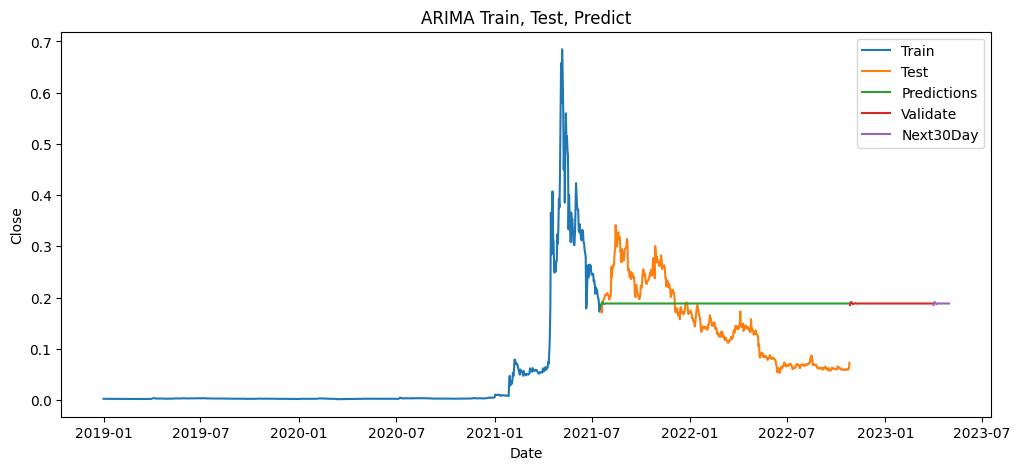

In [14]:
# 9.Vẽ hình
plt.figure(figsize=(12,5), dpi=100)
plt.ylabel('Close');
plt.xlabel('Date');
plt.title('ARIMA Train, Test, Predict')
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(next_30_days_index,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()